### Creations Graphs

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime,date,timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import psycopg2
import pandas.io.sql as psql
from sqlalchemy import create_engine
import sshtunnel 
import pandas as pd
import psycopg2.extras
import csv
import re

In [5]:
#connect to database and get the trips and planned stops for a line
def get_data_from_database(lineId):
    
    #SQL statement
    sql = """Select *
    from regularity_trip
    order by """
    
    
    #database connection

    try:
        sshtunnel.SSH_TIMEOUT = 10.0
        with sshtunnel.SSHTunnelForwarder(
                ('3.83.88.154', 22),
                ssh_username='ec2-user',
                #CHANGE PATH TO rds-example.cer
                ssh_pkey='/Users/lauraforerocamacho/Downloads/rds-example.cer',
                remote_bind_address=('stib-mivb.cjo3cnpt9pci.us-east-1.rds.amazonaws.com', 5432)
        ) as tunnel:
                conn = psycopg2.connect(
                        host='127.0.0.1',
                        port=tunnel.local_bind_port,     
                        database="stibmivbdb",
                        user="postgres",
                        password="stib-mivb-db1")

                cur = conn.cursor()
                #perform sql and write result to dataframe
                cur.execute(sql)
                field_names = [i[0] for i in cur.description]
                query_results = pd.DataFrame(cur.fetchall(),columns=field_names)
                #close connection
                cur.close()
                
                return query_results
    except Exception as e:
            print(e)

    


In [6]:
#insert results to database table assessment_methods
def insert_into_db(df_methods):
    try:
        sshtunnel.SSH_TIMEOUT = 10.0
        with sshtunnel.SSHTunnelForwarder(
                ('3.83.88.154', 22),
                ssh_username='ec2-user',
                #CHANGE PATH TO rds-example.cer
                ssh_pkey='/Users/lauraforerocamacho/Downloads/rds-example.cer',
                remote_bind_address=('stib-mivb.cjo3cnpt9pci.us-east-1.rds.amazonaws.com', 5432)
        ) as tunnel:
                engine = create_engine('postgresql://{user}:{password}@{host}:{port}/{db}'.format(
                        host='127.0.0.1',
                        port=tunnel.local_bind_port,     
                        db="stibmivbdb",
                        user="postgres",
                        password="stib-mivb-db1" ))

                df_methods.to_sql('assessment_methods', engine, if_exists='append',index=False)
    except Exception as e:
            print(e)

In [7]:
#calculate the headway between the planned arrival of the vehicles
#df_stop = data frame with the schedule for one stop (sorted)
def calculate_headway(df_stop):
    d = []
    
    #loop through all entries in df_stop starting at index + 1
    for ind in df_stop.index + 1:
        
        #index in range (schauen ob man den noch eleminieren kann)
        if ind < len(df_stop.index):
            
            #in the following time1 is always the later time (entry with the higher index)
            # time1 get hour from arrival time to deal with times greater 23
            hour = df_stop['arrival_time'][ind][0:2]
            if int(hour) > 23:
                #translate times over 24 hours (24:35 --> 00:35)
                time_str = df_stop['arrival_time'][ind]
                new_time = time_str.replace(hour,str(0) + str(int(hour)-24))
                time1 = datetime.combine(date.min,datetime.strptime(new_time,'%H:%M:%S').time())
                hour = df_stop['arrival_time'][ind-1][0:2]
                
                #same check for time2
                # time2 get hour from arrival time to deal with times greater 23
                if int(hour)> 23:
                    time_str = df_stop['arrival_time'][ind-1]
                    new_time = time_str.replace(hour,str(0) + str(int(hour)-24))
                    time2 = datetime.combine(date.min,datetime.strptime(new_time,'%H:%M:%S').time())

                else:
                    #only time1 greater 23 take for time2 normal arrival time from dataframe
                    time2 = datetime.combine(date.min,datetime.strptime(df_stop['arrival_time'][ind-1],'%H:%M:%S').time())

            else:
                #arrival time from dataframe
                time1 = datetime.combine(date.min,datetime.strptime(df_stop['arrival_time'][ind],'%H:%M:%S').time())
                time2 = datetime.combine(date.min,datetime.strptime(df_stop['arrival_time'][ind-1],'%H:%M:%S').time())
            
            #calculate headway
            headway = time1 - time2
            
            #append to dictionary
            d.append(
                {
                    'Time': df_stop['arrival_time'][ind],
                    'headway': headway.seconds/60,
                }
            )
    
    #create dataframe from dictionary
    df_headways = pd.DataFrame(d)
    return df_headways

In [8]:
#Split data into groups with similar headways 
#returns a list of dataframe every dataframe in the list is a group with similar headway
def form_time_groups(df_headways):
    group_list=[]
    group=[]
    
    #start with the first headway entry
    group.append(
        {
            'Time': df_headways['Time'][0],
            'headway': df_headways['headway'][0],
        }
    )

    #loop through headway dataframe
    for ind in df_headways.index + 1:
        
        #schauen ob anders machen kann
        if ind < len(df_headways.index):
            
            #Calculate the difference of headway between 2 stop times
            headway1 = df_headways['headway'][ind]
            headway2 = df_headways['headway'][ind-1]
            diff = abs(headway1 - headway2)

            #if difference >=2 start a new group (gucken ob hier den Median nehmen kann)
            if diff >= 2:
                #Append current group to goup_list
                df_group = pd.DataFrame(group)
                group_list.append(df_group)
                #create new group
                group.clear()

            #append entry to group
            group.append(
                {
                    'Time': df_headways['Time'][ind],
                    'headway': df_headways['headway'][ind],
                }
            )

    #append last group (if not empty bedingung einbauen)
    df_group = pd.DataFrame(group)
    group_list.append(df_group)

    return group_list

In [9]:
#Create from the time groups the timespans that should be assesed by regularity and the ones that should be assesd by punctuality
def assign_method(group_list,first_time, lineId,direction_id,stopId, date_from, date_to, monday, tuesday, wednesday, thursday, friday, saturday, sunday, route_type):
    
    #first trip in the morning always assesed by punctuality
    timefrom = first_time
    timeto = first_time
    last_method = 'punctuality'

    result=[]
    reg_count=0
    for group in group_list:
        #median headway of the group
        median = group['headway'].median()

        #median <= 12 might be assesd by regularity
        if median <= 12:
            #reg_count = reg_count + 1

            #Regularity only makes sense when at least two vehicles in a row should be assesed by regularity
            if len(group.index) >= 3 or last_method=='regularity':
                method = 'regularity'
            else:
                method = 'punctuality'
        else:
            method = 'punctuality'

        #If last group assessed by the same method merge groups
        if last_method == method:
            timeto = group['Time'].iat[-1]
        else:
        #Add group to dictionary
            timeto = group['Time'].iat[0]
            result.append(
                {
                    'route_id': lineId,
                    'direction_id': direction_id,
                    'stopId': stopId,
                    'time_from': timefrom,
                    'time_to': timeto,
                    'date_from':date_from,
                    'date_to':date_to,
                    'monday': monday,
                    'tuesday': tuesday,
                    'wednesday': wednesday,
                    'thursday': thursday,
                    'friday': friday,
                    'saturday': saturday,
                    'sunday': sunday,
                    'method': last_method,
                    'route_type': route_type,
                    'median_headway':median
                }
            )

            timefrom = timeto
            timeto = group['Time'].iat[-1]

        last_method = method

    #Append result of last loop (check if empty)
    result.append(
            {
                'route_id': lineId,
                'direction_id': direction_id,
                'stopId': stopId,
                'time_from': timefrom,
                'time_to': timeto,
                'date_from':date_from,
                'date_to':date_to,
                'monday': monday,
                'tuesday': tuesday,
                'wednesday': wednesday,
                'thursday': thursday,
                'friday': friday,
                'saturday': saturday,
                'sunday': sunday,
                'method': last_method,
                'route_type': route_type,
                'median_headway':median
            }
    )

    #Create and return dataframe
    df_result = pd.DataFrame(result)
    return df_result

In [10]:

def get_oneexample_regularity():
    df_data_database =  get_data_from_database()
    routes = df_data_database['route_id'].unique()
    for route in routes: 
        route_id = route
        df_route = df_data_database[(df_data_database.route_id == route)]
        #directions
        directions = df_route['direction_id'].unique()
        for direction in directions: 

            #current direction
            direction_id = direction
            df_direction = df_route[(df_data_database.direction_id == direction)]

            service_ids = df_direction['service_id'].unique()

            for service_id in service_ids:

                df_service_id = df_direction[(df_direction.service_id == service_id)]

                if not df_service_id.empty:
                    #details about service id
                    monday = df_service_id['monday'].iat[0]
                    tuesday = df_service_id['tuesday'].iat[0]
                    wednesday = df_service_id['wednesday'].iat[0]
                    thursday = df_service_id['thursday'].iat[0]
                    friday = df_service_id['friday'].iat[0]
                    saturday = df_service_id['saturday'].iat[0]
                    sunday = df_service_id['sunday'].iat[0]
                    date_from = df_service_id['start_date'].iat[0]
                    date_to = df_service_id['end_date'].iat[0]
                    route_type = df_service_id['route_type'].iat[0]


                    df_data_all_stops = df_service_id[['trip_id','arrival_time','departure_time','stop_id']]
                    #get all stops for a line
                    stops = df_data_all_stops['stop_id'].unique()

                        #for every stop determine the schedule
                    for stop in stops:
                        df_stop = df_data_all_stops[(df_data_all_stops.stop_id == stop)]
                        df_stop = df_stop.sort_values(by=['arrival_time'])
                        df_stop = df_stop.reset_index()

                        df_headways = calculate_headway(df_stop)

                        if not df_headways.empty:
                            

                            #check if headways <12 exist (if not assesed by punctuality)
                            if df_headways[df_headways['headway'].apply(np.float32) <= 12].count()['headway'] > 0:
                                #split data into groups with similar headways
                                group_list = form_time_groups(df_headways)
                                time_of_first_vehicle = df_stop['arrival_time'].iat[0]
                                df_methods = assign_method(group_list, time_of_first_vehicle,route_id,direction_id,stop,date_from,date_to,monday,tuesday,wednesday,thursday,friday,saturday,sunday,route_type)
                                print(df_methods)
                                return [df_methods,df_headways,group_list,time_of_first_vehicle]
                            else:
                                result=[]
                                result.append(
                                        {
                                            'route_id': route_id,
                                            'direction_id': direction_id,
                                            'stopId': stop,
                                            'time_from': df_stop['arrival_time'].iat[0],
                                            'time_to': df_stop['arrival_time'].iat[-1],
                                            'date_from':date_from,
                                            'date_to':date_to,
                                            'monday': monday,
                                            'tuesday': tuesday,
                                            'wednesday': wednesday,
                                            'thursday': thursday,
                                            'friday': friday,
                                            'saturday': saturday,
                                            'sunday': sunday,
                                            'method': 'punctuality',
                                            'route_type': route_type,
                                            'median_headway':-1
                                        }
                                    )

                                df_methods = pd.DataFrame(result)
                            
                

In [11]:
example=get_oneexample_regularity()

   route_id  direction_id stopId time_from   time_to   date_from     date_to  \
0         1             0   8012  05:34:48  06:13:37  2021-09-01  2021-09-17   
1         1             0   8012  06:13:37  23:28:01  2021-09-01  2021-09-17   
2         1             0   8012  23:28:01  24:27:01  2021-09-01  2021-09-17   

   monday  tuesday  wednesday  thursday  friday  saturday  sunday  \
0       1        1          1         1       1         0       0   
1       1        1          1         1       1         0       0   
2       1        1          1         1       1         0       0   

        method route_type  median_headway  
0  punctuality          1        5.166667  
1   regularity          1       16.000000  
2  punctuality          1       20.000000  


In [34]:
df_headways_example=example[1]
#pd.to_datetime(df_headways_example["Time"])
df_headways_example.reset_index()

,index,Time,headway
0,0,0 0 05:50:42\n1 05:59:42\n2 ...,15.900000
1,1,0 0 05:50:42\n1 05:59:42\n2 ...,9.000000
2,2,0 0 05:50:42\n1 05:59:42\n2 ...,8.750000
3,3,0 0 05:50:42\n1 05:59:42\n2 ...,5.166667
4,4,0 0 05:50:42\n1 05:59:42\n2 ...,5.166667
...,...,...,...
167,167,0 0 05:50:42\n1 05:59:42\n2 ...,10.000000
168,168,0 0 05:50:42\n1 05:59:42\n2 ...,16.000000
169,169,0 0 05:50:42\n1 05:59:42\n2 ...,19.000000
170,170,0 0 05:50:42\n1 05:59:42\n2 ...,20.000000


<AxesSubplot:xlabel='Time'>

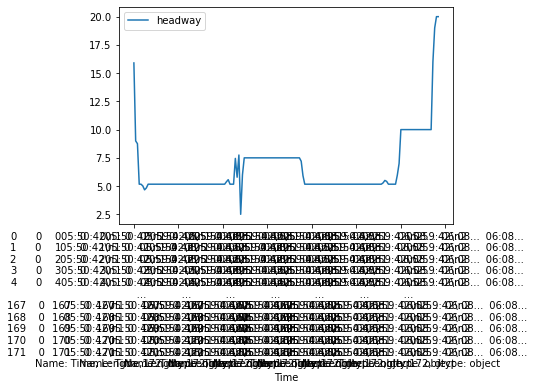

In [40]:
df_headways_example.plot(x=0,y="headway", kind="line" )

<AxesSubplot:ylabel='Time'>

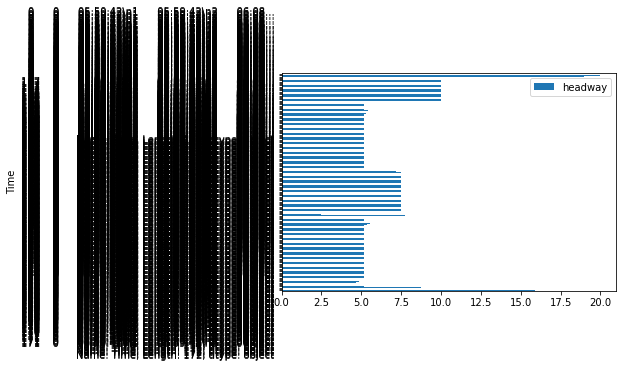

In [42]:
df_headways_example.plot(x=0,y="headway", kind="barh" )